# Dynamic tension of a 1D rod: Lagrangian and Hamiltonian formulations (Neumann bcs)
We are going to solve the propagation of lungitudinal waves using different formulations showing equivalences and differences between them.
The 1D wave equation is given by:
$$ 
\begin{aligned}
\rho A \partial_{tt} q &= \partial_x (EA \partial_x q), \qquad x \in \Omega = [0, L], \quad t \in [0, T_{\mathrm{end}}], \\
\partial_x q(0) &= 0, \qquad \partial_x q(L) = 0, \\
q(x, 0) &= \psi_1(x),  \qquad  \partial_t q(x, 0) = 0.
\end{aligned}
$$

where $q$ is the displacement, $\rho$ the density, $A$ the cross-sectional area and $E$ the Young's modulus and $\psi_1(x)$ is the first mode for the problem.

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from math import pi
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.plot_config import configure_matplotlib
configure_matplotlib()
from IPython.display import HTML

from src.fem import mass_matrix_lagrange, stiffness_matrix, discrete_gradient
from src.time_integration import newmark, stormer_verlet, implicit_midpoint

## Problem Setup
We define the problem parameters and discretize the domain.

In [2]:
# Parameters
length = 1  # Length of the domain (m)
cross_section = 1  # Cross section area (m^2)
density = 1  # Density of the fluid (kg/m^3)
young_modulus = 1 # Young modulus (N/m^2)

T_end = 10  # Total time
n_elements = 10  # Number of spatial elements

n_nodes = n_elements + 1
# Derived parameters
mesh_size = length/ n_elements  # Spatial step size
density_unit_length = density * cross_section
axial_stiffness = young_modulus * cross_section

# Spatial grid
coordinates = np.linspace(0, length, n_elements+1)

# Initial conditions
q_0 = lambda x : np.cos(pi * x/length)  # Initial displacement
v_0 = lambda x : 0*x  # Initial velocity
sigma_0 = lambda x:  - pi / length * axial_stiffness * np.sin(pi*x/length)
q_0_nodes = q_0(coordinates)
v_0_nodes = v_0(coordinates)

##  Construction mass, stiffness and discrete derivative matrices

The mass and stiffness matrix are the usual one obtained for the lowest order Lagrange elements

\begin{equation*}
M_{\rm elem} = \frac{\rho A h}{6}
\begin{bmatrix} 
2 & 1 \\
1 & 2
\end{bmatrix}, \qquad 
K_{\rm elem} = \frac{EA}{h} 
\begin{bmatrix} 
1 & -1 \\
-1 & 1
\end{bmatrix}.
\end{equation*}
The discrete derivative is instead a matrix containing the topological relations between nodes and elements
\begin{equation*}
D_{\rm elem} = 
\begin{bmatrix} 
1 & -1 
\end{bmatrix}.
\end{equation*}

The initial stress is obtained from the initial displacement by using the discrete gradient. This guarantees that the port-Hamiltonian formulation and the Lagrangian formulation are indeed equivalent
\begin{equation*}
\mathbf{s}_0 = \frac{EA}{h} \mathbf{D} \mathbf{q}_0
\end{equation*}

In [6]:
M = mass_matrix_lagrange(coordinates, density_unit_length)
K = stiffness_matrix(coordinates, axial_stiffness)
D = discrete_gradient(coordinates)
diagonal_lumped = [np.sum(M[i, :]) for i in range(M.shape[0])]

M_lumped = sp.diags(diagonal_lumped, offsets=0, format='csr')

sigma_0_elements = axial_stiffness/mesh_size * D @ q_0_nodes

## Choice of the time step

The wave propagation speed is given by:
$$ c = \sqrt{\frac{E}{\rho}}.$$

One may think that it suffices to choose $\Delta t \le h/c$ to obtain a stable scheme but this is not the case. For the explicit Newmark integrator ($\gamma = \frac{1}{2}, \; \beta = 0$), the maximum allowable time step is given by 

$$ dt_\mathrm{max} = \frac{2}{\omega_{\mathrm{max}}}$$

where $\omega_{\mathrm{max}}$ is the maximum eigenvalue of the generalized eigenproblem:

$$\omega^2 \mathbf{M} \boldsymbol{\psi} = \mathbf{K} \boldsymbol{\psi}.$$

Typically a conservative coefficient is introduced $\alpha_{\mathrm{CFL}} = 0.9$:
$$ dt = \alpha_{\mathrm{CFL}} \frac{2}{\omega_{\mathrm{max}}}$$

In [7]:

# Stability condition for explicit scheme
wave_speed = np.sqrt(young_modulus/density)

# Time step based on the wave speed
dt_wave = mesh_size / wave_speed
eigenvalues, _ = sla.eigs(K, M=M, k=1, which='LM')
eigenvalues_lumped, _ = sla.eigs(K, M = M_lumped, k=1, which='LM')

# Time step based on the highest eigenvalue
omega_max = np.sqrt(max(eigenvalues.real))
dt_omega = 2/omega_max

omega_max_lumped = np.sqrt(max(eigenvalues_lumped.real))
dt_omega_lumped = 2/omega_max_lumped

print(f"Time step based on the wave speed: {dt_wave:.3f} [s]")
print(f"Time step based on the max frequency: {dt_omega:.3f} [s]")
print(f"Time step based on the max frequency (lumped mass): {dt_omega_lumped:.3f} [s]")

time_step = 0.9 * dt_omega

# Temporal grid
n_times = int(np.ceil(T_end/time_step))
time_instants = np.linspace(0, T_end, n_times+1)


Time step based on the wave speed: 0.100 [s]
Time step based on the max frequency: 0.058 [s]
Time step based on the max frequency (lumped mass): 0.100 [s]


## Simulation using the Lagrangian form

The newmark integrator takes the following form
\begin{equation*}
\begin{aligned}
    \mathbf{M}_{\rho} \mathbf{a}^{n+1} + \mathbf{K}\mathbf{q}^{n+1} &= 0,  \\
        \frac{\mathbf{v}^{n+1} - \mathbf{v}^n}{\Delta t} &=  \gamma  \mathbf{a}^{n+1} + (1 - \gamma)  \mathbf{a}^{n},  \\
        \frac{\mathbf{q}^{n+1} - \mathbf{q}^n}{\Delta t}&= \mathbf{v}^n + \frac{\Delta t}{2}(2 \beta \mathbf{a}^{n+1} + (1-2\beta) \mathbf{a}^n).
\end{aligned}
\end{equation*}

In [8]:

# # Run the explicit scheme
q_newmark_exp, v_newmark_exp = newmark(q_0_nodes, v_0_nodes, M, K,\
                            time_step, n_times, gamma=0.5, beta=0)

# Run the implicit scheme
q_newmark_imp, v_newmark_imp = newmark(q_0_nodes, v_0_nodes, M, K,\
                            time_step, n_times, gamma=0.5, beta=0.25)


## Simulation using the Hamiltonian form

The hamiltonian form of the problem is 

$$
\begin{pmatrix}
\dot{\mathbf{q}} \\
\dot{\mathbf{p}} \\
\end{pmatrix} = 
\begin{bmatrix}
0 & \mathbf{I} \\
-\mathbf{I} & 0
\end{bmatrix}
\begin{pmatrix}
\partial_{\mathbf{q}} H \\
\partial_{\mathbf{q}} H \\
\end{pmatrix}, \qquad 
H = \frac{1}{2} \mathbf{p}^\top \mathbf{M}^{-1} \mathbf{p} + \frac{1}{2} \mathbf{q}^\top \mathbf{K} \mathbf{q}.
$$

Since the mass matrix is sparse and in real problems very large, we are going with the velocity instead of the linear momentum

$$
\begin{bmatrix}
\mathbf{I} & 0\\
0 & \mathbf{M}_\rho
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{q}} \\
\dot{\mathbf{v}} \\
\end{pmatrix} = 
\begin{bmatrix}
0 & \mathbf{I} \\
-\mathbf{I} & 0
\end{bmatrix}
\begin{pmatrix}
\mathbf{K} \mathbf{q} \\
\mathbf{v} \\
\end{pmatrix}, \qquad 
H = \frac{1}{2} \mathbf{v}^\top \mathbf{M} \mathbf{v} + \frac{1}{2} \mathbf{q}^\top \mathbf{K} \mathbf{q}.
$$
A general syntax is used for the stormer-verlet integrator.

In [9]:
sparse_eye = sp.identity(n_nodes)
q_stverlet, v_stverlet = stormer_verlet(q_0_nodes, v_0_nodes,\
                                    M, sparse_eye, - K, \
                                    time_step, n_times)

x_at_0 = np.concatenate((q_0_nodes, v_0_nodes))

M_ham = sp.block_diag([sp.identity(n_nodes), M])

A_row1_ham = sp.hstack([sp.csr_matrix((n_nodes, n_nodes)), sparse_eye])
A_row2_ham = sp.hstack([- K, sp.csr_matrix((n_nodes, n_nodes))])
A_ham = sp.vstack([A_row1_ham, A_row2_ham])

x_ham_implicit = implicit_midpoint(x_at_0, M_ham, A_ham, time_step, n_times)

q_ham_implicit = x_ham_implicit[:, :n_nodes]
v_ham_implicit = x_ham_implicit[:, n_nodes:]

If instead the port-Hamiltonian form is considered, the system make take two dual forms. The primal one is equivalent to the classical Lagrangian discretization 

\begin{equation*}
\begin{bmatrix}
\mathbf{M}_c & 0 \\
0 & \mathbf{M}_\rho
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{s}} \\
\dot{\mathbf{v}}
\end{pmatrix} = 
\begin{bmatrix}
0 & - \mathbf{D}^\top \\
\mathbf{D} & 0 \\
\end{bmatrix}
\begin{pmatrix}
{\mathbf{s}} \\
{\mathbf{v}}
\end{pmatrix}
\end{equation*}

In the case $\mathbf{M}_c$ is block-diagonal. For degree 0 discontinuous elements, it takes the form 
\begin{equation*}
\mathbf{M}_c = \frac{h}{EA} \mathbf{I}
\end{equation*}

The dual system represents a mixed discretization, where the stress is represented by a continuos filed and the velocity is instead discontinuous

\begin{equation*}
\begin{bmatrix}
\mathbf{M}_c & 0 \\
0 & \mathbf{M}_\rho
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{s}} \\
\dot{\mathbf{v}}
\end{pmatrix} = 
\begin{bmatrix}
0 & \mathbf{D} \\
- \mathbf{D}^\top & 0 \\
\end{bmatrix}
\begin{pmatrix}
{\mathbf{s}} \\
{\mathbf{v}}
\end{pmatrix}
\end{equation*}

In the case $\mathbf{M}_\rho$ is block-diagonal (diagonal for degree 0 discontinuous elements).


We can employ the same integrators as before, but now using the port-Hamiltonian system. 


In [10]:
A_1 = axial_stiffness/mesh_size*D

sigma_mixed_sv, v_mixed_sv = stormer_verlet(sigma_0_elements, v_0_nodes, 
                                                            M, A_1, - D.T,\
                                                            time_step, n_times)

x_at_0 = np.concatenate((sigma_0_elements, v_0_nodes))

M_mixed = sp.block_diag([mesh_size/axial_stiffness * sp.identity(n_elements), M])

A_row1_mix = sp.hstack([sp.csr_matrix((n_elements, n_elements)), D])
A_row2_mix = sp.hstack([- D.T, sp.csr_matrix((n_nodes, n_nodes))])
A_mix = sp.vstack([A_row1_mix, A_row2_mix])

x_mixed_imp = implicit_midpoint(x_at_0, M_mixed, A_mix, time_step, n_times)

s_mixed_imp = x_mixed_imp[:, :n_elements]
v_mixed_imp = x_mixed_imp[:, n_elements:]

Reconstruction of the displacement via the trapezoidal rule

In [11]:
q_mixed_sv = np.zeros((1 + n_times, n_nodes))
q_mixed_sv[0, :] = q_0_nodes

q_mixed_imp = np.zeros((1 + n_times, n_nodes))
q_mixed_imp[0, :] = q_0_nodes

for ii in range(n_times):
    q_mixed_sv[ii+1, :] = q_mixed_sv[ii, :] + time_step * v_mixed_sv[ii, :]
    q_mixed_imp[ii+1, :] = q_mixed_imp[ii, :] + 0.5*time_step * (v_mixed_imp[ii, :] + v_mixed_imp[ii+1, :])


## Visualization
We set the parameters for the display options

In [12]:
step_animation = 10
interval_frames = time_step * step_animation * 1000

First we compare the Explicit Newmark with Stormer-Verlet and the Implicit Newmark with the implicit midpoint

In [13]:
fig, ax = plt.subplots()
line1, = ax.plot(coordinates, q_stverlet[0, :] - q_newmark_exp[0, :], label="SV Ham and Exp. Newmark" )
line2, = ax.plot(coordinates, q_stverlet[0, :] - q_mixed_sv[0, :], label="SV Ham and Mixed")
line3, = ax.plot(coordinates, q_ham_implicit[0, :] - q_newmark_imp[0, :], label="IM Ham and Imp. Newmark" )
line4, = ax.plot(coordinates, q_ham_implicit[0, :] - q_mixed_imp[0, :], label="IM Ham and Mixed")
ax.set_xlim(0, length)
ax.set_ylim(-10**(-12), 10**(-12))

ax.set_xlabel('$x$')
ax.set_ylabel('$q$')
ax.set_title('Difference of displacement (explicit)')
ax.legend()
ax.grid(True)
plt.close()

def update(ii):
    line1.set_ydata(q_stverlet[ii, :] - q_newmark_exp[ii, :])
    line2.set_ydata(q_stverlet[ii, :] - q_mixed_sv[ii, :])
    line3.set_ydata(q_ham_implicit[ii, :] - q_newmark_imp[ii, :])
    line4.set_ydata(q_ham_implicit[ii, :] - q_mixed_imp[ii, :])
    ax.set_title(f"Displacement $t= {ii*time_step:.1f}$ [s]")
    return line1, line2, line3, line4

anim = animation.FuncAnimation(fig, update, frames=range(0, n_times, step_animation), \
                               blit=True, interval=interval_frames)



In [14]:
HTML(anim.to_html5_video())

In [15]:
fig, ax = plt.subplots()
line1, = ax.plot(coordinates, q_newmark_exp[0, :], label='Explicit Newmark')
line2, = ax.plot(coordinates, q_newmark_imp[0, :], label='Implicit Newmark')

ax.set_xlim(0, length)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('$x$')
ax.set_ylabel('$q$')
ax.set_title('Displacement')
ax.legend()
ax.grid(True)
plt.close()

def update(ii):
    line1.set_ydata(q_newmark_exp[ii, :])
    line2.set_ydata(q_newmark_imp[ii, :])
    ax.set_title(f"Displacement $t= {ii*time_step:.1f}$ [s]")
    return line1, line2,


anim = animation.FuncAnimation(fig, update, frames=range(0, n_times, step_animation), \
                               blit=True, interval=interval_frames)

In [16]:
HTML(anim.to_html5_video())

Plot of the energy for the implicit and explicit scheme

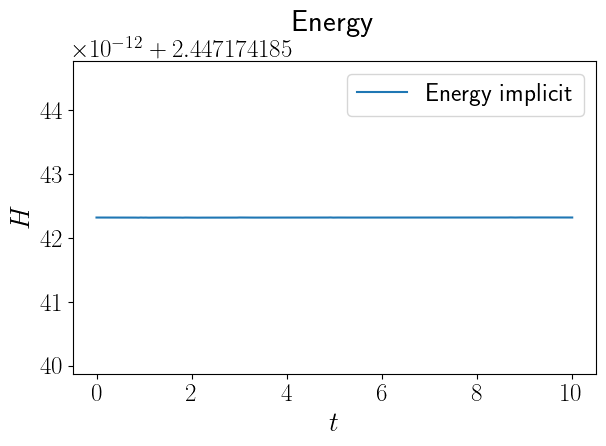

In [18]:
energy_explicit = np.zeros(n_times+1)
energy_implicit = np.zeros(n_times+1)

for ii in range(1+n_times):
    energy_explicit[ii] = 0.5 * np.dot(v_newmark_exp[ii], M @ v_newmark_exp[ii]) + \
                          0.5 * np.dot(q_newmark_exp[ii], K @ q_newmark_exp[ii])
    
    energy_implicit[ii] = 0.5 * np.dot(v_newmark_imp[ii], M @ v_newmark_imp[ii]) + \
                          0.5 * np.dot(q_newmark_imp[ii], K @ q_newmark_imp[ii])


fig, ax = plt.subplots()
ax.plot(time_instants, energy_explicit, label='Energy explicit')
ax.plot(time_instants, energy_implicit, label='Energy implicit')
ax.set_xlabel('$t$')
ax.set_ylabel('$H$')
ax.set_title('Energy')
ax.legend()
plt.show()
